# Summary

*Author: Benjamin Bradshaw*

In this notebook we will finally start getting to the exciting stuff: machine learning! We did the necessary preprocessing, splitting, and feature engineering and now it's time to start the iterative building process. As mentioned in the previous notebook, rather than creating all possible useful features, we will begin with the few we constructed and build a very basic classifier. Depending on how well that does we may decide we need to go back to the drawing board and either collect more data, design better features, or choose a different model.

This notebook will introduce a few topics which you may have seen before but we feel are particularly useful in an applied setting. These topics include:
- Cross validation
- The notion of a test set score and a training set score as they relates to bias and variance
- Various performance metrics that are utilized both in machine learning circles as well as clinical circles

# Learning objectives

By the time you work through this notebook you should be able to:
- Use cross validation for the purposes of hyperparameter tuning on the development (training) set
- Understand the implications of disparities in training and testing set performance for model choice and hyperparameter tuning
- Conceptually understand why regularization is often necesassary for prediction tasks
- Implement a basic machine learning pipeline for a clasification task

# Initialize
Dependencies. . .

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import utils # Utility functions containained in ./utils/
import scipy
import seaborn as sns

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('max.rows', 100)
pd.set_option('max.columns', 100)
sns.set_style('darkgrid')

# Change this location to the path where you would like your data saved to
data_dir = '/Users/bbradshaw/nhanes/'

# Path to hdf store we will create later
hdf_path = 'nhanes.h5'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Read in only training set features for now
train_features = pd.read_hdf(os.path.join(data_dir, hdf_path), 'train_features')

In [3]:
train_features.head()

,seqn,day,first_step_minute,last_step_minute,max_steps,sum_steps,pct_nonzero_steps,max_rolling_30,first_morning_step_minute,is_weekend,gender,currently_in_school,household_size,age_in_years
0,31129.0,2,354.0,1432.0,116.0,9533.0,35.208332,690.133362,354.0,0,1.0,1.0,6.0,15.0
1,31129.0,3,147.0,1287.0,112.0,10285.0,41.666668,758.533325,383.0,0,1.0,1.0,6.0,15.0
2,31129.0,5,378.0,1359.0,109.0,9768.0,38.541668,661.366638,378.0,0,1.0,1.0,6.0,15.0
3,31129.0,6,375.0,1414.0,115.0,9102.0,38.333332,693.400024,375.0,0,1.0,1.0,6.0,15.0
4,31131.0,1,451.0,1221.0,110.0,11888.0,47.013889,719.066650,451.0,1,2.0,-1.0,4.0,44.0


# Building a machine learning pipeline

Now it's time to get our hands dirty. In order to build a functional pipeline there are several design choices we need to consider:
- How do we handle missing values?
- How do we choose a model?
- How do we choose model hyperparameters?

We'll go over each of these, but first let's talk about cross validation.

## Cross validation

Cross validation is a powerful tool for both building a model that generalizes to unseen examples, as well as tuning hyperparameters and slecting a model. The idea is rather than splitting our dev set into a separate training and validation set (like we did for the development-testing set) we will use the entire development set and split it into k disjoint folds. We will then train the model on (k-1) of the folds, and use the kth fold for validation. We will repeat this process k times, each time using a different fold for validation. The benefits of this method are twofold. First, this process is much more efficient in term sof data usage. Essentially we are using the entire dataset (at one point or another) to formulate generalization estimates. Second, this method yields a *distribution* over metrics of interest. For example, suppose we are interested in comparing the AUROC of several models. Since many models contain stochastic components, a comparison of a single train-validation split may give us misleading information. However, computing k AUROC scores for each model allows us to build bootstrapped confidence intervals around the true value of interest.

The image below gives a visual explanation of how cross validation works.

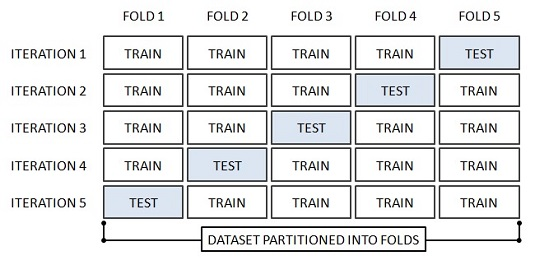

In [9]:
Image(filename='../supplementary_materials/cv_image.jpg')

## Constructing a preprocessign pipeline

Pretty much all machine learning models require all values for all features to be specified. For that to be the case, we need to impute missing values before they are input to the model. In order to do this we need to talk a bit about feature types. Take a look at the figure blow. It gives a break down of the two main types of data we will need to address for input into a model.

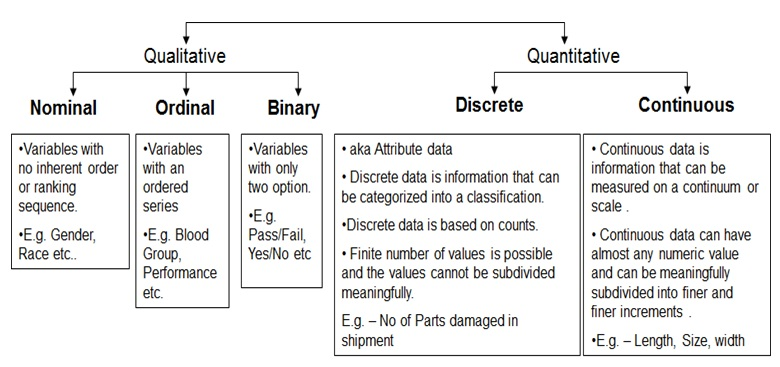

In [10]:
Image(filename='../supplementary_materials/data_types.jpg')

In [12]:
# Let's look at our variables and see what dtypes
# they map to
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12118 entries, 0 to 12117
Data columns (total 14 columns):
seqn                         12118 non-null object
day                          12118 non-null int64
first_step_minute            12117 non-null float32
last_step_minute             12117 non-null float32
max_steps                    12111 non-null float32
sum_steps                    12118 non-null float32
pct_nonzero_steps            12117 non-null float32
max_rolling_30               12111 non-null float32
first_morning_step_minute    12117 non-null float32
is_weekend                   12118 non-null int64
gender                       12118 non-null float64
currently_in_school          12118 non-null float64
household_size               12118 non-null float64
age_in_years                 12118 non-null float64
dtypes: float32(7), float64(4), int64(2), object(1)
memory usage: 1.1+ MB


In [228]:
# Map variables to types

# Features to exclude from the model
excl_feats = ['seqn', 'day']

# Numeric features
numeric_feats = [
    'first_step_minute',
    'last_step_minute',
    'max_steps',
    'sum_steps',
    'pct_nonzero_steps',
    'max_rolling_30',
    'first_morning_step_minute',
    'age_in_years'
]

# Categorical features
categorical_feats = [
    'gender',
    'currently_in_school',
    'household_size'
]

# Dummy variable names
dummy_feats = list(
    pd.get_dummies(
        train_features[categorical_feats]
    ).columns
)

In [121]:
# Check how many null values there are for each feature
train_features.isnull().sum()

seqn                         0
day                          0
first_step_minute            1
last_step_minute             1
max_steps                    7
sum_steps                    0
pct_nonzero_steps            1
max_rolling_30               7
first_morning_step_minute    1
is_weekend                   0
gender                       0
currently_in_school          0
household_size               0
age_in_years                 0
dtype: int64

In [218]:
# Turn categorical variables into strings for one-hot encoding
for feat in categorical_feats:
    train_features[feat] = train_features[feat].astype('category')

You can see most features have no missing values, but there are a few. We need to come up with a strategy for filling these values. There are two items to note here:
- Typically the strategy you use for imputing numeric variables is not the same as for computing categorical variables
- When imputing values we almost always impute missing values in the test set with statistics computed in the training set. This prevents us from a very nefarious situation known as *label leaking* which we will talk about a bit later.

For simplicity, we will use the median value of each numeric feature to fill missing values, and the mode of each feature to fill categorical features. In practice there are much more complicated schemes, and you can select the right strategy by using cross validation. However, this choice is usually a reasonable baseline and tends to work just fine.

In [268]:
# These are utilities for preprocessing- you should 
# review them for your own code edification
from utils import DataFrameSelector, DummyGenerator

In [230]:
# The sklearn Pipeline class allows us to string together
# transformations into a single flow,
# Here we construct two pipelines: one for numeric features
# and one for categorical features. We then union them together
# into a single pipeline.

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric_feats)),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('dummy_generator', DummyGenerator(categorical_feats))
    ])

full_pipeline = FeatureUnion(transformer_list=[
    
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

The above code isn't long but it's procedurally dense. It abstracts A LOT of the process of selecting the correct datatypes, applying an appropriate transform, and then glueing everything back together. Since this is meant to illustrate more the process than the details, I won't review what's going on under the hood in gory detail. With that being said: I highly recommend you take the time to review both the sklearn docs to better understand what each of the pieces of functionality do individually. Ideally, you should code these up yourself for practice.

## Defining a performance metric

Phew! We have finally arrived! We downloaded the data, did QC checks, constructed features, and built a preprocessing pipeline. It's time to test a model! Remember: building a machine learning system is an iterative process. We will implement a very basic model, and we will measure its performance. If it does "good enough" for the use case at hand then great, we are done! If not, we have decisions to make: do we need better features? Do we have enough/the right data? Is our model too simple? Too complex? These are some of the questions we will need to address as we build our system.

How does one go about defining "good enough"? A lot of this depends on the specific use case. Suppose you were building a classifier that detected a rare disease. Would you care more about limiting false positives or limiting false negatives? Listed below are several important definitions you should be familiar with. They take some time to master but are foundational for reasoning about the performance of a machine learning system. Most of these metrics are functions of the *confusion matrix* which designates the distribution of a model's predictions across the true class labels. The figure below gives a nice overview.

- **Accuracy:** The proportion of cases your algorithm accurately classified (TP + TN) / (TP + FP + TN + FN)
- **Recall (sensitivity):** The proportion of positive cases your algorithm correctly identified as such (TP) / (TP + FN)
- **Precision (positive predictive value):** The proportion of cases your algorithm identified as the positive case, that were correct (TP) / (TP + FP)
- **Specificity**: The proportion of negative classes your algorithm correctly identified as such (TN) / (TN + FP)
- **Negative predictive value:** The proportion of cases your algorithm identified as the negative class, that were correct (TN) / (TN + FN)

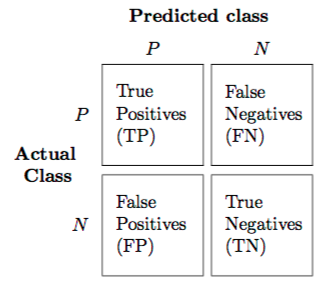

In [135]:
Image('../supplementary_materials/confusion_matrix.png')

In [273]:
# First step - separate out y (our target) and X (our feature matrix)

# is_weekend is our target
y = train_features.is_weekend.values

# Extract out the features we care about as defined above
X = train_features[numeric_feats+categorical_feats].values

# Extract groups so we keep indivual peron data in the same fold
groups = train_features.seqn.values

In [36]:
# Classification metrics for validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# This is a helper function that abstracts the cross validation
# implementation
from sklearn.model_selection import cross_val_score

In [35]:
# Models to try out
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [39]:
# Random forest is a stochastic algorithm - let's set a seed for 
# reproduceability

# Nothing special about this number
random_seed = 42

In [302]:
# For now use pretty much the set defaults, except
# use class_weight-'balanced' since our classes are imbalanced 4:1
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lr = LogisticRegression(class_weight='balanced', C=0.01)
svm = SVC(kernel="poly", degree=3, coef0=1, C=5, probability=True)

In [231]:
# Fit and transform features with our preprocessing pipeline
X_clean = full_pipeline.fit_transform(train_features)

In [163]:
# Compute a few of the metrics mentioned above
metrics = {
    'accuracy': None,
    'recall': None,
    'precision': None,
    'roc_auc': None
}

for key in metrics.keys():
    # Note this is inefficient: I am training the model (5 folds) x (4 metrics) = 20 times
    metrics[key] = cross_val_score(rf, X_clean, y, scoring=key, cv=5)

In [169]:
for m in metrics:
    print('metric:', m, '\n')
    print('mean:', metrics[m].mean(), '\n')
    print('std:', metrics[m].std(), '\n')
    print('---------------------------------------------------')

metric: accuracy 

mean: 0.779005772611163 

std: 0.005504894913829659 

---------------------------------------------------
metric: recall 

mean: 0.12712168371127908 

std: 0.016818617891652 

---------------------------------------------------
metric: precision 

mean: 0.44556140853619 

std: 0.04533761289617405 

---------------------------------------------------
metric: roc_auc 

mean: 0.6727511971864226 

std: 0.011225671650526028 

---------------------------------------------------


Are the above metrics good? Let's think about it. Across folds my model has a mean accuracy of almost 78%: which at first glance seems pretty good. But on second though what would the accuracy of an extremely dumb model that always guess not weekend be? If I always guessed 0, then my sensitivity would be 100% and I would correctly identify all non-weekend days. Since the classes are unbalanced by definition (weekends vs weekdays) our accuracy will always look pretty good. Looking at the positive class proportion:

In [191]:
# Accuracy looks pretty good! Recall not so much. . . .
1 - y.sum() / len(y)

0.785773229905925

## The AUROC Metric

The above analysis tells us that in some ways our model is better than a naive model, in some ways it really isn't. How do we compare models using a metric that shows the trade offs in performance along different levels of operation? Perhaps the most wel known metric is the *Receiver Operating CHaracteristic Curve* which plots the true postive rate (recall or sensitivity) against the false postive rate (1-specificity) for various decision threshold boundaries. The area under this curve is known as AUROC (not suprisingly). A value of 0.5 implies that the classifier is no better than random, while  value of 1 indicates the classifier is able to perfectly discriminate between classes.

In [192]:
# This utility builds the ROC curve with k folds
# computing the AUROC for each held out set
from utils import plot_roc_with_cv

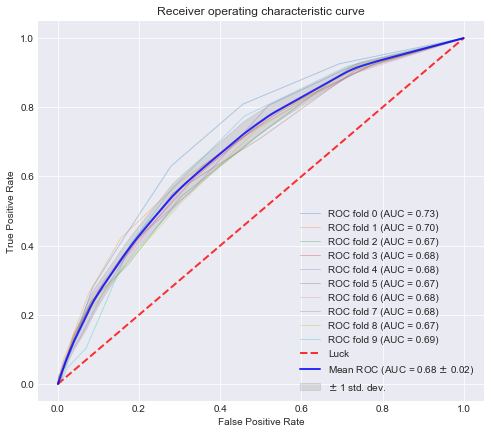

In [274]:
# Random forest AUROC is significantly better than random but not excellent.
plot_roc_with_cv(X=prepped, y=y, classifier=rf, groups=groups, cv=10)

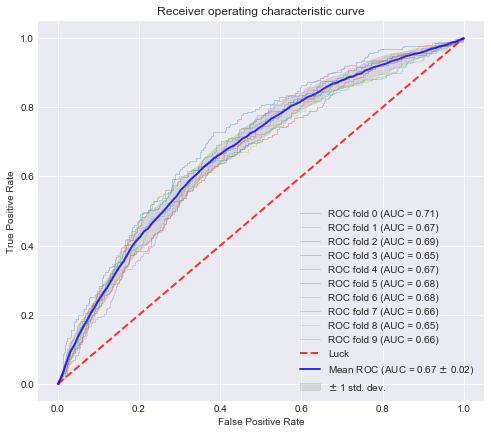

In [275]:
# Let's try logistic regression
plot_roc_with_cv(X=prepped, y=y, classifier=lr, groups=groups, cv=10)

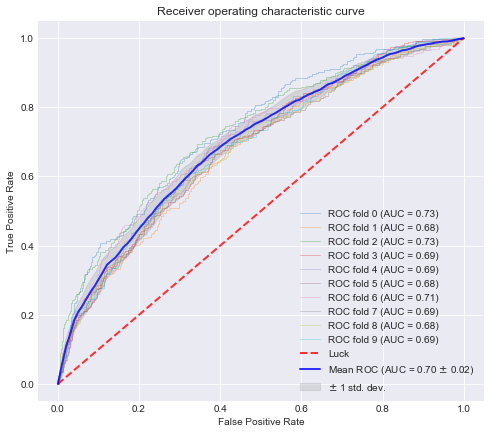

In [303]:
# Random forest AUROC is significantly better than random but not excellent.
plot_roc_with_cv(X=prepped, y=y, classifier=svm, groups=groups, cv=10)

## Hyperparameter tuning

Now that we have two candidate models we want to tune our models to get more performance out of them. There is a powerful tool for determining which hyperparameters are best and it again involves cross validation. This tool is called randomized search. The basic idea is to specify a distribution over the parameters that you want to try. The randomized search will then sample values over this multidimensional space and keep track of the combination that performs best using cross validation. Let's give it a shot.

In [203]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_param_distribs = {
    'n_estimators': randint(low=1, high=500),
    'max_features': randint(low=1, high=11),
    'max_depth': randint(low=1, high=15),
    'min_samples_split': randint(low=2, high=100)
    }

rf = RandomForestClassifier(
    random_state=random_seed,
    n_jobs=-1,
    class_weight='balanced'
)

rnd_search = RandomizedSearchCV(
    rf,
    param_distributions=rf_param_distribs,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    random_state=random_seed
)

rnd_search.fit(X_clean, y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x111222898>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x110f20208>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x110e3cc18>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x110e3c550>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          r

In [204]:
# Save the best estimator in a new object
best_rf = rnd_search.best_estimator_

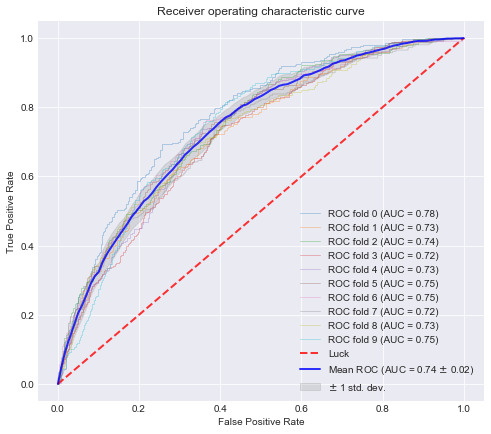

In [276]:
# How much better is our AUROC with the tuned model?
plot_roc_with_cv(X=prepped, y=y, classifier=best_rf, groups=groups, cv=10)

In [207]:
# Other metrics of interest
metrics = {
    'accuracy': None,
    'recall': None,
    'precision': None,
    'roc_auc': None
}

for key in metrics.keys():
    # Note this is inefficient: I am training the model (5 folds) x (4 metrics) = 20 times
    metrics[key] = cross_val_score(best_rf, X_clean, y, scoring=key, cv=5)

In [208]:
for m in metrics:
    print('metric:', m, '\n')
    print('mean:', metrics[m].mean(), '\n')
    print('std:', metrics[m].std(), '\n')
    print('---------------------------------------------------')

metric: accuracy 

mean: 0.7054769211049794 

std: 0.013023243008830758 

---------------------------------------------------
metric: recall 

mean: 0.5924640580998963 

std: 0.032242635692944284 

---------------------------------------------------
metric: precision 

mean: 0.38042012334852227 

std: 0.01187389672396064 

---------------------------------------------------
metric: roc_auc 

mean: 0.7378376269486074 

std: 0.0069436956542271696 

---------------------------------------------------


Tuning the model hyperparameters gave us a solid jump in AUC. We went from a mean AUC of 0.68 to a mean AUC of 0.74. That's a significant lift for a minimal amount of work. Interestingly, accuracy actually fell by quite a bit. This is because the model is getting more aggressive in predicting the postive class: We went from a recall of 0.12 to a recall of 0.59: an enormous jump. Unfortunately this came at the cost of a reduced precision. This is typical when building a classifier: there is a tradeoff between precision and recall.

## Feature Importances

Often times and especially in clinical contexts the interpretability of the model is extremely important since we will present our results to clinicians. One of the nice things about random forests and logistic regression is they feature importances/weights respectively that give insight into how the model is making its decisions.

In [234]:
feature_set = numeric_feats + dummy_feats

In [256]:
# Write a little function that extracts feature importances (if
# they exist) and sort them by the absolute magnitude value
def get_feature_importances(trained_model, feature_list):
    if hasattr(trained_model, 'feature_importances_'):
        importances = pd.DataFrame(
            {'importance': trained_model.feature_importances_},
            index=feature_list
        )
        return importances.sort_values(by='importance', ascending=False)
    elif hasattr(trained_model, 'coef_'):
        importances = pd.DataFrame(
            {
                'coefficient': trained_model.coef_[0],
                'abs_weight': abs(trained_model.coef_[0])
            },
            index=feature_list
        )
        return importances.sort_values(by='abs_weight', ascending=False).drop('abs_weight', axis=1)
    else:
        raise AttributeError('Model does not have feature importance or coefficient attribute!')

In [263]:
# Extract random forest feature importances
rf_feature_imp = get_feature_importances(best_rf, feature_set)

# Extract logistic regression feature importances
lr_feature_imp = get_feature_importances(lr, feature_set)

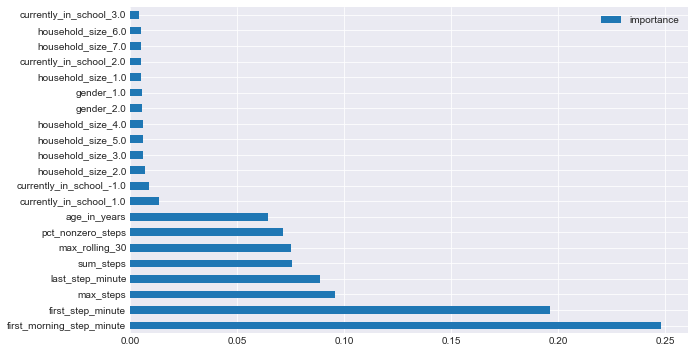

In [269]:
rf_feature_imp.plot(kind='barh', figsize=(10, 6));

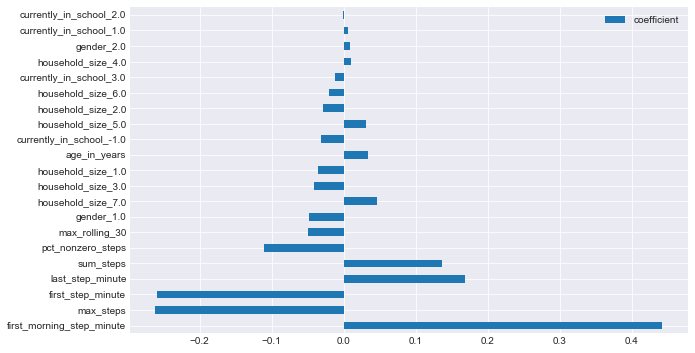

In [270]:
lr_feature_imp.plot(kind='barh', figsize=(10, 6));

The feature importances are reassuring, we see that when you wake up in the morning is the most important factor the model decides when it determines whether or not the target is a weekend. A cool result! Interestingly, we also see that the logistic regression finds that weekends are associated with lower single minute maximum step count values.

# System evaluation and diagnostics

Now that we have a few working prototypes that are promising, if we decide our performance is not good enough we need to think about where the best place is to invest our efforts in improving the system. We have a few options:

- **Collect better data:** Maybe the data we have isn't sufficient for the task at hand
- **Collect more data:** Maybe we simply haven't exposed the algorithm to enough data in order for it to learn the optimal decision rule
- **Construct better features:** Perhaps the amount of information in the underlying signal is sufficient for the problem at hand, but our features don't capture that signal. Note that this is the allure of neural networks: given enough data they can learn the features on their own. Unfortunately, often times we don't have the kind of data necessary to learn these features.
- **Choose a different model:** It's possible our model either is too simple to capture the complexity of the data, or it is too complex and is overfitting the training data. We will dive into how to diagnose if this is the case.

## TODO: Bias, variance, and noise


In [287]:
from sklearn.svm import SVC

/Users/bbradshaw/venv3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/bbradshaw/venv3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


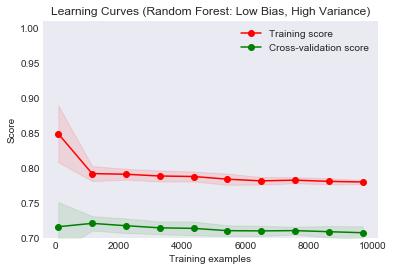

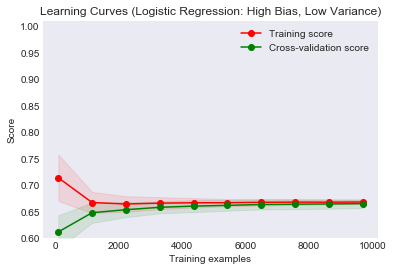

In [308]:
from sklearn.model_selection import ShuffleSplit, learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.01, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Random Forest: Low Bias, High Variance)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = best_rf
plot_learning_curve(estimator, title, X_clean, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Logistic Regression: High Bias, Low Variance)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(C=0.1, class_weight='balanced')
plot_learning_curve(estimator, title, X_clean, y, (0.6, 1.01), cv=cv, n_jobs=4)

plt.show()